In [49]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy
from collections import OrderedDict
import random
import csv

In [2]:
%load_ext PWE_NB_Extension

In [3]:
def turn_list_into_str(l):
    # small bug fix 
    if isinstance(l, (list,set,frozenset)):
        if len(l) > 1:
            l_ = [turn_list_into_str(l1) for l1 in l[1:]]
            return "{}({})".format(l[0], ",".join(l_))
        elif len(l) == 1:
            return "{}".format(l[0])
        else:
            return ""
    else:
        return l


In [4]:
testData = '/home/mj1e16/abduction/pwe/testData/qfix_synthetic_example/synth_1_dirty_0.csv'
testQueries = '/home/mj1e16/abduction/pwe/testData/qfix_synthetic_example/qlog_clean.csv'

In [5]:
testQueries = '/home/mj1e16/abduction/pwe/testData/qfixNew/qfix_sync/synth/qlog_New.csv'

In [6]:
dataSet = []
with open(testData,'r') as csvfile:
    reader = csv.reader(csvfile,delimiter=' ',quotechar='|')
    for row in reader:
        dataSet.append([', '.join(row)])

In [7]:
dataSetOnly = dataSet[1:]
originalSchema = dataSet[0][0].upper()
endSchema = originalSchema.replace(',',',END')
end = 'END'
endSchema = end + endSchema
clingo_rules = ['% schema data('+originalSchema+',PROV)']
clingo_rules.append(['% schema e(DATAEND,DATASTART,TRANS)'])

In [8]:
schemaList = dataSet[0][0]+ ',COLOUR,TRANS,'
schemaList += endSchema
schemaList = schemaList.split(",")

In [11]:
with open(testQueries,'r') as f:
    data = f.read()
#print(data)    
queries = data.split('\n')
#print(queries)

In [15]:
def sql2clingo(sqlCommand,originalSchema,colour='black'):
    sql = sqlCommand.replace('"','')
    sqlList = sql.split(' ') 
    #print(sqlList)
    schemaList = originalSchema.split(',')
    #print(schemaList)
    clingoString = 0
    #print(sqlList[0])
    if sqlList[0] == 'UPDATE':
        sql = sql.replace(' = ','=')
        sql = sql.replace(' > ','>')
        sql = sql.replace(' < ','<')
        sql = sql.replace(' >= ','>=')
        sql = sql.replace(' <= ','<=')
        sql = sql.replace(',','')
        sqlList = sql.split(' ') 
        setLoc = sqlList.index('SET')
        whereLoc = sqlList.index('WHERE')
        setCommands = sqlList[setLoc+1:whereLoc]
        setCommands = [x.upper() for x in setCommands]
        whereCommands = sqlList[whereLoc+1:]
        whereCommands = [x.upper() for x in whereCommands if x != 'AND']
        whereCommandsString = '-'.join(whereCommands)
        whereCommandsComma = ','.join(whereCommands)
        setLocs = [x[:x.index('=')] for x in setCommands]
        setValues = [x[x.index('=')+1:] for x in setCommands]
        setVals = []
        startSetVals = []
        for x in (schemaList):
            if x in setLocs:
                loc = setLocs.index(x)
                setVals.append(setValues[loc])
                startSetVals.append('_')
            else:
                setVals.append(x)
                startSetVals.append(x)
        setValsString = ','.join(setVals)
        #clingoString = 'data('+setValsString+',black,"'+whereCommandsString+'",'+originalSchema+') :- data('+originalSchema+',_,_,_,_,_,_,_,_,_),'+whereCommandsComma+'.'
        clingoString = 'e(data('+setValsString+',prov(P,"'+whereCommandsString+'")),data('+originalSchema+',P),trans('+colour+',"'+whereCommandsString+'")) :- data('+originalSchema+',P),'+whereCommandsComma+'.'
    if sqlList[0] == 'INSERT':
        locator = 'VALUES('
        loc1 = sql.index(locator)
        loc2 = sql[loc1:].index(')')+loc1
        datavalues = sql[loc1+len(locator):loc2]
        datavaluesDash = datavalues.replace(',','-')
        clingoString = 'data('+datavalues+',"INSERT'+datavaluesDash+'").'
    
    return clingoString

In [17]:
commands = []
for x in queries:
    clingoString = sql2clingo(x,originalSchema)
    if clingoString != 0:
        commands.append(clingoString)
        
#commands

In [18]:
ASPRules('\n'.join(commands))

'e(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").\ndata(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(52,4,71,99,59,39,17,"INSERT52-4-71-99-59-39-17").\ne(data(ID,A0,95,27,A3,A4,A5,prov(P,"A1=96-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=96-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=96,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").\ndata(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(52,4,71,99,59,39,17,"INSERT52-4-71-99-59-39-17").\ne(data(ID,A0,44,54,A3,A4,A5,prov(P,"A4>=24-A4<34-A2>=3-A2<13")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=24-A4<34-A2>=3-A2<13")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=24,A4<34,A2>=3,A2<13.\ndata(50,46,32,38,90,53,56,"INSERT50-46-32-38-90-53-56").\ndata(51,2,32,13,51,100,68,"INSERT51-2-32-13-51-100-68").\ndata(52,90,80,74,91,77,79,"INSERT52-90-80-74-91-77-79").\ne(data(ID,A0,16,97,A3,A4,A5,prov(P,"A4>=68-A4<78-A2>=65-A2<75")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=68-A4<78-A2>=65-A2<75")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=68,A4<78,A2>=65,A2<75.\ne(data(ID,A0,93,49,A3,A4,A5,prov(P,"A4>=45-A4<55-A2>=75-A2<85")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=45-A4<55-A2>=75-A2<85")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=45,A4<55,A2>=75,A2<85.\ne(data(ID,A0,46,90,A3,A4,A5,prov(P,"A4>=51-A4<61-A2>=83-A2<93")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=51-A4<61-A2>=83-A2<93")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=51,A4<61,A2>=83,A2<93.\ne(data(ID,A0,32,22,A3,A4,A5,prov(P,"A0=70-A2=16")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A0=70-A2=16")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A0=70,A2=16.\ne(data(ID,A0,31,92,A3,A4,A5,prov(P,"A0=96-A2=71")),data(ID,A0,A1,A2,A3,

In [19]:
def makeOriginal(dataValues,colour='black'):
    clingoStart = []
    for x in dataValues:
        clingoStart.append('data('+','.join(x)+',"").')
    return clingoStart

In [20]:
originalSetup = makeOriginal(dataSetOnly)

In [21]:
ASPRules('\n'.join(originalSetup))

'data(0,13,85,77,27,52,48,"").\ndata(1,65,79,11,5,85,46,"").\ndata(2,76,1,46,73,26,95,"").\ndata(3,91,4,4,56,95,41,"").\ndata(4,21,43,4,24,46,52,"").\ndata(5,23,24,23,48,32,7,"").\ndata(6,84,56,65,21,100,87,"").\ndata(7,12,34,73,72,94,45,"").\ndata(8,83,68,32,60,89,86,"").\ndata(9,51,59,5,26,81,44,"").\ndata(10,17,55,71,69,40,47,"").\ndata(11,51,78,53,41,51,7,"").\ndata(12,4,71,99,61,42,21,"").\ndata(13,50,99,78,55,87,27,"").\ndata(14,51,96,59,47,30,57,"").\ndata(15,96,1,79,83,89,76,"").\ndata(16,81,52,57,44,9,88,"").\ndata(17,57,20,51,50,38,38,"").\ndata(18,54,63,62,47,6,27,"").\ndata(19,17,59,87,81,81,83,"").\ndata(20,25,85,68,11,5,6,"").\ndata(21,76,25,12,64,37,11,"").\ndata(22,16,53,18,29,73,48,"").\ndata(23,32,48,4,40,44,23,"").\ndata(24,10,90,52,23,62,83,"").\ndata(25,2,2,16,73,19,72,"").\ndata(26,68,55,23,98,81,54,"").\ndata(27,22,65,41,59,35,65,"").\ndata(28,5,30,97,88,33,87,"").\ndata(29,31,94,75,43,28,5,"").\ndata(30,88,4,83,97,59,21,"").\ndata(31,87,98,71,52,40,38,"").\ndata(32,20,68,44,22,14,68,"").\ndata(33,29,50,34,88,91,6,"").\ndata(34,20,33,99,79,36,25,"").\ndata(35,68,84,94,36,89,70,"").\ndata(36,48,99,25,74,12,21,"").\ndata(37,92,22,77,61,85,40,"").\ndata(38,34,30,87,62,96,90,"").\ndata(39,13,56,12,6,11,88,"").\ndata(40,79,83,35,63,79,41,"").\ndata(41,57,23,10,29,90,59,"").\ndata(42,93,46,29,80,84,6,"").\ndata(43,67,10,13,89,7,28,"").\ndata(44,99,43,13,19,27,76,"").\ndata(45,10,92,39,98,92,33,"").\ndata(46,25,48,11,66,7,6,"").\ndata(47,99,30,61,47,34,11,"").\ndata(48,92,97,98,13,24,64,"").\ndata(49,98,55,70,67,29,56,"").'

In [22]:
def addConversion(dataValues):
    variables = []
    spaces = ['_']*len(dataValues)
    #underscores = ','.join(spaces)
        
    variables = [chr(65+x) for x in range(len(dataValues))]
    clingoHead = 'data('+','.join(variables)+',P) :-'
    clingoBody = 'e(data('+','.join(variables)+',P),data('+','.join(spaces)+',P),trans(_,T)).'
    
    
    return clingoHead+clingoBody

In [24]:
edgeNodeConv = addConversion(originalSchema.split(','))

In [25]:
ASPRules(edgeNodeConv)

'data(A,B,C,D,E,F,G,P) :-e(data(A,B,C,D,E,F,G,P),data(_,_,_,_,_,_,_,P),trans(_,T)).'

In [26]:
clingo_rules = ['% schema data('+originalSchema+',prov)','% schema e(DATAEND,DATASTART,TRANS)']
clingo_rules.extend(originalSetup)
clingo_rules.extend(commands)
clingo_rules.extend([edgeNodeConv])

In [27]:
ASPRules('\n'.join(clingo_rules)) 

'% schema data(ID,A0,A1,A2,A3,A4,A5,prov)\n% schema e(DATAEND,DATASTART,TRANS)\ndata(0,13,85,77,27,52,48,"").\ndata(1,65,79,11,5,85,46,"").\ndata(2,76,1,46,73,26,95,"").\ndata(3,91,4,4,56,95,41,"").\ndata(4,21,43,4,24,46,52,"").\ndata(5,23,24,23,48,32,7,"").\ndata(6,84,56,65,21,100,87,"").\ndata(7,12,34,73,72,94,45,"").\ndata(8,83,68,32,60,89,86,"").\ndata(9,51,59,5,26,81,44,"").\ndata(10,17,55,71,69,40,47,"").\ndata(11,51,78,53,41,51,7,"").\ndata(12,4,71,99,61,42,21,"").\ndata(13,50,99,78,55,87,27,"").\ndata(14,51,96,59,47,30,57,"").\ndata(15,96,1,79,83,89,76,"").\ndata(16,81,52,57,44,9,88,"").\ndata(17,57,20,51,50,38,38,"").\ndata(18,54,63,62,47,6,27,"").\ndata(19,17,59,87,81,81,83,"").\ndata(20,25,85,68,11,5,6,"").\ndata(21,76,25,12,64,37,11,"").\ndata(22,16,53,18,29,73,48,"").\ndata(23,32,48,4,40,44,23,"").\ndata(24,10,90,52,23,62,83,"").\ndata(25,2,2,16,73,19,72,"").\ndata(26,68,55,23,98,81,54,"").\ndata(27,22,65,41,59,35,65,"").\ndata(28,5,30,97,88,33,87,"").\ndata(29,31,94,75,43,28,5,"").\ndata(30,88,4,83,97,59,21,"").\ndata(31,87,98,71,52,40,38,"").\ndata(32,20,68,44,22,14,68,"").\ndata(33,29,50,34,88,91,6,"").\ndata(34,20,33,99,79,36,25,"").\ndata(35,68,84,94,36,89,70,"").\ndata(36,48,99,25,74,12,21,"").\ndata(37,92,22,77,61,85,40,"").\ndata(38,34,30,87,62,96,90,"").\ndata(39,13,56,12,6,11,88,"").\ndata(40,79,83,35,63,79,41,"").\ndata(41,57,23,10,29,90,59,"").\ndata(42,93,46,29,80,84,6,"").\ndata(43,67,10,13,89,7,28,"").\ndata(44,99,43,13,19,27,76,"").\ndata(45,10,92,39,98,92,33,"").\ndata(46,25,48,11,66,7,6,"").\ndata(47,99,30,61,47,34,11,"").\ndata(48,92,97,98,13,24,64,"").\ndata(49,98,55,70,67,29,56,"").\ne(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").\ndata(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(52,4,71,99,59,39,17,"INSERT52-4-71-99-59-39-17").\ne(data(ID,A0,95,27,A3,A4,A5,prov(P,"A1=96-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=96-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=96,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").\ndata(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :-

In [28]:
%clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

Output:


'Answer: 1\ndata(0,13,85,77,27,52,48,"") data(1,65,79,11,5,85,46,"") data(2,76,1,46,73,26,95,"") data(3,91,4,4,56,95,41,"") data(4,21,43,4,24,46,52,"") data(5,23,24,23,48,32,7,"") data(6,84,56,65,21,100,87,"") data(7,12,34,73,72,94,45,"") data(8,83,68,32,60,89,86,"") data(9,51,59,5,26,81,44,"") data(10,17,55,71,69,40,47,"") data(11,51,78,53,41,51,7,"") data(12,4,71,99,61,42,21,"") data(13,50,99,78,55,87,27,"") data(14,51,96,59,47,30,57,"") data(15,96,1,79,83,89,76,"") data(16,81,52,57,44,9,88,"") data(17,57,20,51,50,38,38,"") data(18,54,63,62,47,6,27,"") data(19,17,59,87,81,81,83,"") data(20,25,85,68,11,5,6,"") data(21,76,25,12,64,37,11,"") data(22,16,53,18,29,73,48,"") data(23,32,48,4,40,44,23,"") data(24,10,90,52,23,62,83,"") data(25,2,2,16,73,19,72,"") data(26,68,55,23,98,81,54,"") data(27,22,65,41,59,35,65,"") data(28,5,30,97,88,33,87,"") data(29,31,94,75,43,28,5,"") data(30,88,4,83,97,59,21,"") data(31,87,98,71,52,40,38,"") data(32,20,68,44,22,14,68,"") data(33,29,50,34,88,91,6,"") data(34,20,33,99,79,36,25,"") data(35,68,84,94,36,89,70,"") data(36,48,99,25,74,12,21,"") data(37,92,22,77,61,85,40,"") data(38,34,30,87,62,96,90,"") data(39,13,56,12,6,11,88,"") data(40,79,83,35,63,79,41,"") data(41,57,23,10,29,90,59,"") data(42,93,46,29,80,84,6,"") data(43,67,10,13,89,7,28,"") data(44,99,43,13,19,27,76,"") data(45,10,92,39,98,92,33,"") data(46,25,48,11,66,7,6,"") data(47,99,30,61,47,34,11,"") data(48,92,97,98,13,24,64,"") data(49,98,55,70,67,29,56,"") data(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46") data(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100") data(52,4,71,99,59,39,17,"INSERT52-4-71-99-59-39-17") data(50,46,32,38,90,53,56,"INSERT50-46-32-38-90-53-56") data(51,2,32,13,51,100,68,"INSERT51-2-32-13-51-100-68") data(52,90,80,74,91,77,79,"INSERT52-90-80-74-91-77-79") data(51,2,32,10,51,100,68,"INSERT51-2-32-10-51-100-68") data(50,64,87,52,74,67,6,"INSERT50-64-87-52-74-67-6") data(51,6,86,99,8,80,41,"INSERT51-6-86-99-8-80-41") data(52,29,77,88,4,62,4,"INSERT52-29-77-88-4-62-4") data(51,6,86,4,8,80,41,"INSERT51-6-86-4-8-80-41") data(50,82,4,4,63,28,53,"INSERT50-82-4-4-63-28-53") data(51,33,17,46,4,70,90,"INSERT51-33-17-46-4-70-90") e(data(30,88,4,91,30,59,21,prov("","A4>=52-A4<62-A2>=80-A2<90")),data(30,88,4,83,97,59,21,""),trans(black,"A4>=52-A4<62-A2>=80-A2<90")) e(data(16,81,52,88,86,9,88,prov("","A4>=7-A4<17-A2>=55-A2<65")),data(16,81,52,57,44,9,88,""),trans(black,"A4>=7-A4<17-A2>=55-A2<65")) e(data(8,67,68,32,60,16,86,prov("","A0>=78-A0<88-A4>=87-A4<97")),data(8,83,68,32,60,89,86,""),trans(black,"A0>=78-A0<88-A4>=87-A4<97")) e(data(1,59,79,11,5,91,46,prov("","A0>=62-A0<72-A4>=84-A4<94")),data(1,65,79,11,5,85,46,""),trans(black,"A0>=62-A0<72-A4>=84-A4<94")) e(data(35,59,84,94,36,91,70,prov("","A0>=62-A0<72-A4>=84-A4<94")),data(35,68,84,94,36,89,70,""),trans(black,"A0>=62-A0<72-A4>=84-A4<94")) e(data(5,23,59,65,48,32,7,prov("","A4>=28-A4<38-A2>=18-A2<28")),data(5,23,24,23,48,32,7,""),trans(black,"A4>=28-A4<38-A2>=18-A2<28")) e(data(30,88,46,90,97,59,21,prov("","A4>=51-A4<61-A2>=83-A2<93")),data(30,88,4,83,97,59,21,""),trans(black,"A4>=51-A4<61-A2>=83-A2<93")) e(data(0,13,93,49,27,52,48,prov("","A4>=45-A4<55-A2>=75-A2<85")),data(0,13,85,77,27,52,48,""),trans(black,"A4>=45-A4<55-A2>=75-A2<85")) e(data(52,90,16,97,91,77,79,prov("INSERT52-90-80-74-91-77-79","A4>=68-A4<78-A2>=65-A2<75")),data(52,90,80,74,91,77,79,"INSERT52-90-80-74-91-77-79"),trans(black,"A4>=68-A4<78-A2>=65-A2<75")) e(data(50,82,44,54,63,28,53,prov("INSERT50-82-4-4-63-28-53","A4>=24-A4<34-A2>=3-A2<13")),data(50,82,4,4,63,28,53,"INSERT50-82-4-4-63-28-53"),trans(black,"A4>=24-A4<34-A2>=3-A2<13")) e(data(4,21,78,52,24,46,52,prov("","A1>=35-A1<45-A4>=44-A4<54")),data(4,21,43,4,24,46,52,""),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) e(data(9,51,67,30,26,81,44,prov("","A1>=53-A1<63-A4>=80-A4<90")),data(9,51,59,5,26,81,44,""),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) e(data(19,17,67,30,81,81,83,prov("","A1>=53-A1<63-A4>=80-A4<90")),data(19,17,59,87,81,81,83,

In [29]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo',internal_facts_as_string=False)

Number of Models: 1


In [30]:
pw_rels_dfs.keys()
#edge_rel_name = 'data_16'

dict_keys(['data_8', 'e_3'])

In [31]:
pwe_e3_new_format = pw_rels_dfs['e_3'].applymap(turn_list_into_str)
pwe_data3_new_format = pw_rels_dfs['data_8'].applymap(turn_list_into_str)

In [32]:
def smallConvert(string):
    b = string.replace('data(','')
    b = b[:-1]
    c = b.replace('),',')\n')
    return c

In [33]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

startNode = []
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    if len(row['prov']) == 2:
        startNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')

In [34]:
startNodeNewformat = '\n'.join(startNode)

In [35]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeDict["start"] = [x for x in startNode]
num=0
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov'] :
        insertNode = [x for x in startNode]
        insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
        #print(insertNode)
        insertNodeList.append(insertNode)
        insertNodeProv.append(row['prov'])
        nodeDict[row['prov']] = insertNode

In [36]:
insertNodeNewformat = ['\n'.join(x) for x in insertNodeList]

In [ ]:
totNodes = []

In [37]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeDict["start"] = [x for x in startNode]
num=0
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov'] :
        insertNode = [x for x in startNode]
        insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
        #print(insertNode)
        insertNodeList.append(insertNode)
        insertNodeProv.append(row['prov'])
        nodeDict[row['prov']] = insertNode

In [40]:
provTraces = []
for i, row in pw_rels_dfs['e_3'].iterrows():
    provTraces.append(row['DATAEND'][-1][1:])
    
print(provTraces)
#uniqueProvTraces = set(provTraces)

[['""', '"A4>=52-A4<62-A2>=80-A2<90"'], ['""', '"A4>=7-A4<17-A2>=55-A2<65"'], ['""', '"A0>=78-A0<88-A4>=87-A4<97"'], ['""', '"A0>=62-A0<72-A4>=84-A4<94"'], ['""', '"A0>=62-A0<72-A4>=84-A4<94"'], ['""', '"A4>=28-A4<38-A2>=18-A2<28"'], ['""', '"A4>=51-A4<61-A2>=83-A2<93"'], ['""', '"A4>=45-A4<55-A2>=75-A2<85"'], ['"INSERT52-90-80-74-91-77-79"', '"A4>=68-A4<78-A2>=65-A2<75"'], ['"INSERT50-82-4-4-63-28-53"', '"A4>=24-A4<34-A2>=3-A2<13"'], ['""', '"A1>=35-A1<45-A4>=44-A4<54"'], ['""', '"A1>=53-A1<63-A4>=80-A4<90"'], ['""', '"A1>=53-A1<63-A4>=80-A4<90"'], ['""', '"A1>=53-A1<63-A4>=80-A4<90"']]


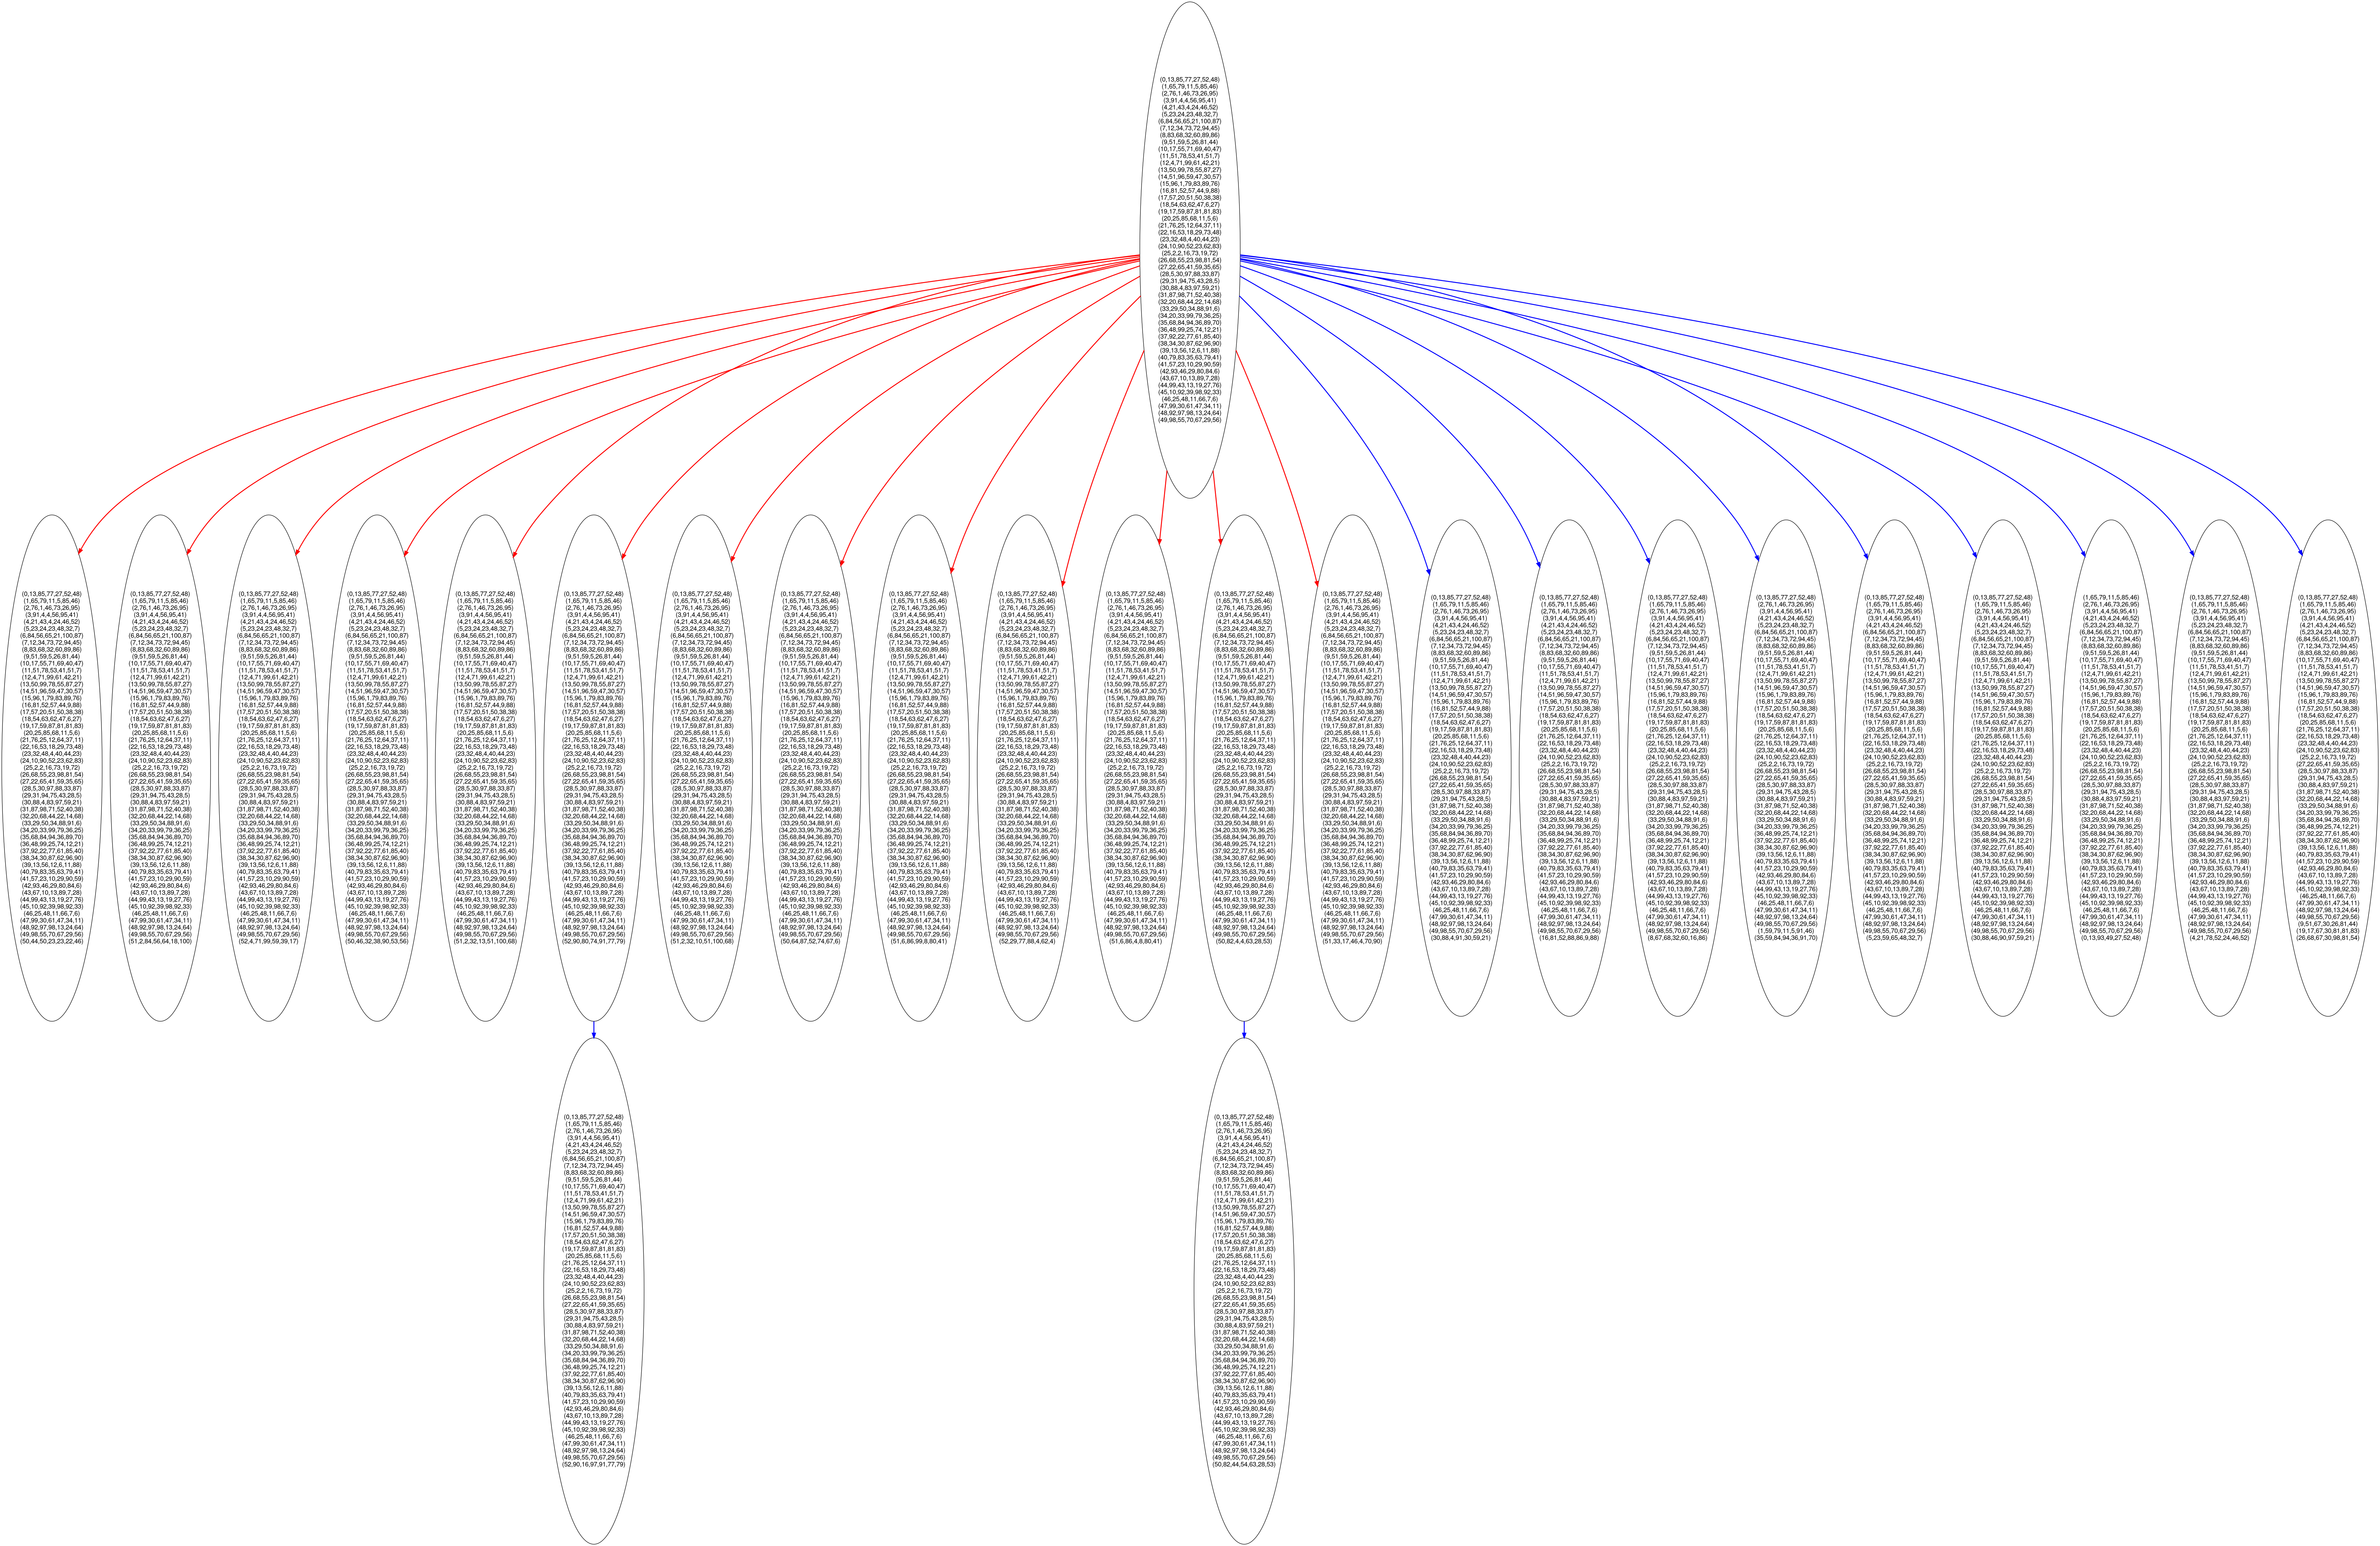

In [62]:
G = nx.DiGraph()
start = '\n'.join(startNode)
edges = []
provlist = []

for inserts in insertNodeList:
    endInsert = '\n'.join(inserts)
    G.add_edge(start,endInsert,penwidth=2,color='red')
    edges.append((start,endInsert))
    
for prov in provTraces:
    startNodeSingle = []
    endNodeSingle = []
    startNode2Ignore = []
    
    for i, row in pw_rels_dfs['e_3'].iterrows():
        singleProv = [row['DATASTART'][-1],row['TRANS'][2]]
        if singleProv == prov:
            endNodeSingle.append('('+"{}".format(','.join(row['DATAEND'][1:-1])+')'))
            startNode2Ignore.append('('+"{}".format(','.join(row['DATASTART'][1:-1])+')'))
            startProv = row['DATASTART'][-1]

    provlist.append(startProv)
    if len(startProv) == 2:
        startProv = 'start'
    startNodeSingle = nodeDict[startProv]
    endNodeBase = [x for x in nodeDict[startProv] if x not in startNode2Ignore]
    endNodeBase.extend(endNodeSingle)
    
    
    startNodeSingle = '\n'.join(startNodeSingle)
    endNodeSingle = '\n'.join(endNodeBase)
    nodeDict[prov[1]] = endNodeBase
    G.add_edge(startNodeSingle,endNodeSingle,penwidth=2,color='blue')
    edges.append((startNodeSingle, endNodeSingle))

    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'

draw(G,format='png',filename='qfixLarge.png')

In [89]:
start = nodeDict['start']
startNode = '\n'.join(start)

In [86]:
nodeKeys = list(nodeDict.keys())
targetNum = 10
targets = []
for x in range(targetNum):
    targets.append(random.randint(0,len(nodeDict)-1))

targetPos = [nodeDict[nodeKeys[x]] for x in targets]
targetNewFormat = ['\n'.join(t) for t in targetPos]

In [93]:
def getGraphStats(G,target,start):
    allPaths = []
    #for sources in dataValuesNonStr:
    singlePath = []
    for path in nx.all_simple_paths(G,source=start,target=target):
        singlePath.append(path)
    allPaths.append(singlePath)
    APP = len(allPaths[0])
    
    allPSorted = sorted(allPaths[0])
    allPSet = set(frozenset(x) for x in allPSorted)
    DIFF = [list(x) for x in allPSet]
    DIFFNUM = len(DIFF)
    
    minPath = nx.shortest_path(G,start,target)
    smallpp = len(minPath)
    
    return [APP,DIFFNUM,smallpp]

In [94]:
stats = getGraphStats(G,targetNewFormat[0],startNode)

In [97]:
statyBojangles = []
for x in targetNewFormat:
    statyBojangles.append(getGraphStats(G,x,startNode))

In [98]:
statyBojangles

[[1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 3],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2]]